# Modeling elections

In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 4 columns, representing Clinton, Trump, Johnson, and Stein in that order. In the example below, Clinton got 340 votes in the first survey, Trump got 258, Johnson got 27, and Stein got 13.
```
  >>> survey_results['Indiana']
  array([[340, 258,  27,  13],
         [240, 155,   5,   5],
         [235, 155,  50,  20],
         [308, 266,  49,  35],
         [222, 161,  80,  30]])
```
Data from [Wikipedia: Statewide opinion polling for the United States presidential election, 2016](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_United_States_presidential_election,_2016)


In [3]:
electoral_votes = {
    #'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    #'Alabama': np.array([], dtype=int).reshape(0, 4),
    'Alaska': np.array([400 * np.array([.47, .43, .07, .03]), 500 * np.array([.36, .37, .07, .03]), 500 * np.array([.34, .37, .10, .02]), 660 * np.array([.31, .36, .18, .06])], dtype=int),
    'Arizona': np.array([392 * np.array([.45, .47, .05, .02]), 550 * np.array([.39, .47, .04, .03]), 719 * np.array([.40, .45, .09, .03]), 769 * np.array([.44, .49, .05, .01]), 2229 * np.array([.45, .44, .07, .01]), 700 * np.array([.43, .47, .02, .02]), 550 * np.array([.41, .45, .03, .01]), 994 * np.array([.42, .44, .04, .01]), 550 * np.array([.40, .42, .05, .02]), 2385 * np.array([.48, .46, .05, .01]), 401 * np.array([.45, .46, .04, .01]), 550 * np.array([.41, .41, .05, .02]), 1538 * np.array([.39, .44, .06, .02]), 713 * np.array([.43, .38, .06, .01]), 400 * np.array([.39, .37, .08, .03]), 600 * np.array([.44, .42, .09, .01]), 718 * np.array([.42, .42, .05, .01]), 484 * np.array([.41, .46, .09, .01]), 649 * np.array([.38, .40, .12, .03])], dtype=int),
    'Arkansas': np.array([463 * np.array([.33, .56, .04, .02]), 831 * np.array([.34, .55, .03, .01]), 600 * np.array([.29, .57, .05, .03])], dtype=int),
    'Colorado': np.array([1150 * np.array([.45, .44, .05, .04]), 500 * np.array([.44, .38, .07, .02]), 550 * np.array([.39, .39, .05, .04]), 750 * np.array([.44, .41, .08, .04]), 685 * np.array([.45, .37, .10, .03]), 400 * np.array([.49, .38, .07, .03]), 602 * np.array([.44, .33, .10, .03]), 694 * np.array([.46, .40, .06, .02]), 784 * np.array([.41, .42, .13, .03]), 991 * np.array([.40, .39, .07, .02]), 644 * np.array([.44, .42, .10, .02]), 540 * np.array([.41, .34, .12, .03]), 600 * np.array([.38, .42, .13, .02]), 704 * np.array([.48, .43, .04, .02]), 605 * np.array([.43, .38, .07, .02]), 997 * np.array([.42, .39, .07, .02])], dtype=int),
}

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 4 states with 29 electoral college votes


In [61]:
survey_results['Alaska']

array([[188, 172,  28,  12],
       [180, 185,  35,  15],
       [170, 185,  50,  10],
       [204, 237, 118,  39]])

## Generative model

1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 4 candidates whenever we do a survey — including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 4 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

### Tasks

* Use Stan to sample from the posterior distribution over $\alpha$ and visualize your results. There are 10 states, so you will have 10 posteriors.
* The posteriors over $\alpha$ show a lot of variation between different states. Explain the results you get in terms of the model and the data.

In [4]:
stan_code = '''
data {
    int<lower=1> Candidates; //column in dataset
    int<lower=1> Surveys; //row in dataset
    int votes[Surveys, Candidates]; // dataset!
}

parameters {
    simplex[Candidates] prob[Surveys]; // 
    vector[Candidates] alpha; // α  vector, which defines a Dirichlet
                              // distribution over the proportion of votes that go to 
                              // each of the 4 candidates whenever we do a survey
}

model {
    alpha ~ cauchy(0, 1); // cauchy distribution prior with location 0 and scale 1
    for (i in 1:Surveys) {
        prob[i] ~ dirichlet(alpha); // prob vector represenitng probabiltiies 
                                    //that a voter selects each of the 4 candidates
                                    
        votes[i] ~ multinomial(prob[i]); // number of votes going to each candidate using multinomial
    }
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_de135508b3f481059d3d70e311654ad9 NOW.


In [ ]:
results = []
for state in survey_results:
    state_data = {
        'Surveys': len(survey_results[state]),
        'Candidates': 4,
        'votes': survey_results[state]
    }
    result = stan_model.sampling(data=state_data)
    results.append(result)
    
alaska_results = results[0]
arizona_results = results[1]
arkansas_results = results[2]
colorado_results = results[3]

In [ ]:
#ALASKA

print('SURVEY DATA:')
print(survey_results['Alaska'])
print()
print(alaska_results.stansummary(pars='prob',probs=(0.025, 0.975)))
print(alaska_results.stansummary(pars='alpha',probs=(0.025, 0.975)))



samples = alaska_results.extract()
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i+0.8, scale=0.4, \
                               size=samples['alpha'].shape[0]), \
                             samples['alpha'][:,i], ',', alpha=2)
    
plt.xticks(range(1,5),["Clinton","Trump","Johnson","Stein"])
plt.title('Distribution over each component of alpha (Alaska)')
plt.show()

Inference for Stan model: anon_model_cebad6654ed75d304f7ef5fa399df9f9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[0]  89.65    0.83  25.65   49.7 150.14    950    1.0
alpha[1]  93.24    0.86  26.74  51.31  156.2    957    1.0
alpha[2]  12.19    0.12   3.59   6.68   20.9    946    1.0
alpha[3]   3.54    0.03   1.02   1.93   5.98   1098    1.0

Samples were drawn using NUTS at Wed Feb 26 00:20:16 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


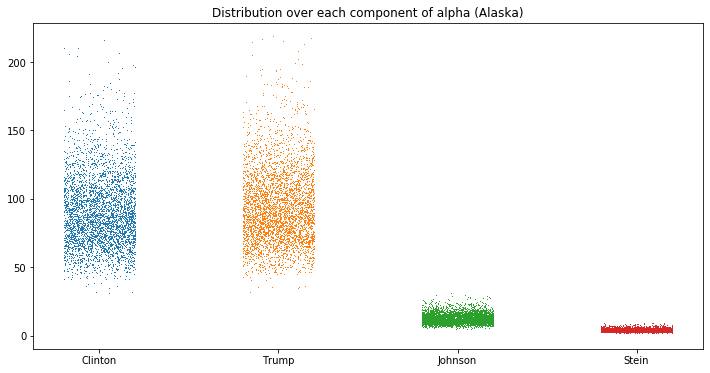

In [76]:
#ARIZONA

print(arizona_results.stansummary(pars='alpha',probs=(0.025, 0.975)))

samples = arizona_results.extract()
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i+0.8, scale=0.4, \
                               size=samples['alpha'].shape[0]), \
                             samples['alpha'][:,i], ',', alpha=2)
    
plt.xticks(range(1,5),["Clinton","Trump","Johnson","Stein"])
plt.title('Distribution over each component of alpha (Arizona)')
plt.show()

Inference for Stan model: anon_model_cebad6654ed75d304f7ef5fa399df9f9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[0]  18.87    0.74  15.29   2.56  58.38    431    1.0
alpha[1]  33.12    1.27  26.84   4.27  99.65    445    1.0
alpha[2]    2.5    0.09   1.91   0.48   7.75    459    1.0
alpha[3]   1.39    0.04   0.92   0.32   3.79    583    1.0

Samples were drawn using NUTS at Wed Feb 26 00:20:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


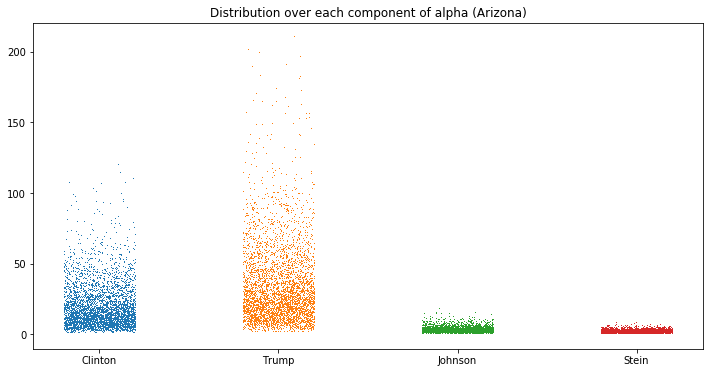

In [77]:
#ARKANSAS

print(arkansas_results.stansummary(pars='alpha',probs=(0.025, 0.975)))

samples = arkansas_results.extract()
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i+0.8, scale=0.4, \
                               size=samples['alpha'].shape[0]), \
                             samples['alpha'][:,i], ',', alpha=2)
    
plt.xticks(range(1,5),["Clinton","Trump","Johnson","Stein"])
plt.title('Distribution over each component of alpha (Arizona)')
plt.show()

Inference for Stan model: anon_model_cebad6654ed75d304f7ef5fa399df9f9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[0]  90.96    0.84  27.22   47.8 153.44   1046    1.0
alpha[1]  82.78    0.77   24.8  43.52 139.76   1034    1.0
alpha[2]  16.65    0.15   5.06   8.48   28.1   1080    1.0
alpha[3]   5.75    0.05   1.73   3.06   9.79   1124    1.0

Samples were drawn using NUTS at Wed Feb 26 00:20:25 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


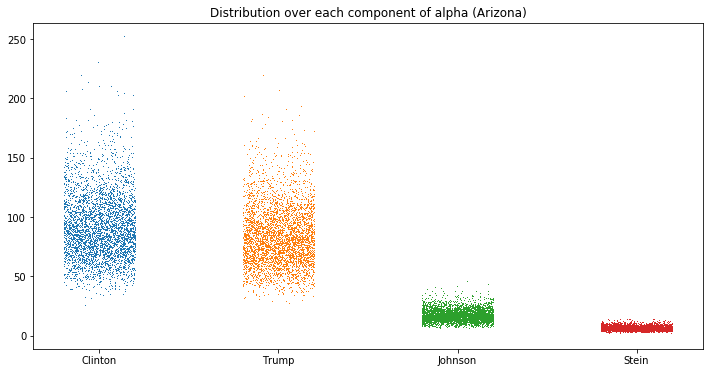

In [78]:
#COLORADO

print(colorado_results.stansummary(pars='alpha',probs=(0.025, 0.975)))

samples = colorado_results.extract()
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(stats.uniform.rvs(loc=i+0.8, scale=0.4, \
                               size=samples['alpha'].shape[0]), \
                             samples['alpha'][:,i], ',', alpha=2)
    
plt.xticks(range(1,5),["Clinton","Trump","Johnson","Stein"])
plt.title('Distribution over each component of alpha (Arizona)')
plt.show()

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ — the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

In [110]:
states_predicted = []
for result in results:
    samples = result.extract()
    
    # Make a new array with same dimensions as alpha
    p_predicted = np.empty(samples['alpha'].shape)
    
    # Generate one p sample for each alpha sample
    for i in range(samples['alpha'].shape[0]):
        p_predicted[i] = stats.dirichlet(samples['alpha'][i]).rvs()
        
    states_predicted.append(p_predicted)
    
alaska_predicted_results = states_predicted[0]
arizona_predicted_results = states_predicted[1]
arkansas_predicted_results = states_predicted[2]
colorado_predicted_results = states_predicted[3]

In [112]:
candidates = ["Clinton","Trump","Johnson","Stein"]
#Clinton wins Colorado. Trump wins Alaska, Arizona and Arkansas. 

print("In Alaska:")
for i in range(4):
    print(candidates[i],":", np.mean(alaska_predicted_results.T[i]))
print("____________________________________")

print("In Arizona:")
for i in range(4):
    print(candidates[i],":", np.mean(arizona_predicted_results.T[i]))
print("____________________________________")

print("In Arkansas:")
for i in range(4):
    print(candidates[i],":", np.mean(arkansas_predicted_results.T[i]))
print("____________________________________")

print("In Colorado:")
for i in range(4):
    print(candidates[i],":", np.mean(colorado_predicted_results.T[i]))

In Alaska:
Clinton : 0.405709325033
Trump : 0.424383481786
Johnson : 0.119636561852
Stein : 0.0502706313298
____________________________________
In Arizona:
Clinton : 0.451549559944
Trump : 0.469135271783
Johnson : 0.0614018137067
Stein : 0.0179133545659
____________________________________
In Arkansas:
Clinton : 0.336156485884
Trump : 0.582584686934
Johnson : 0.0505867264596
Stein : 0.030672100722
____________________________________
In Colorado:
Clinton : 0.463269395754
Trump : 0.422474536321
Johnson : 0.0844778290749
Stein : 0.0297782388507


In [ ]:
def win(states_predicted):
    